# Grad-CAM 


In [1]:
import math
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as TD
from torch.autograd import Variable
from collections import OrderedDict
# from resnet import *
from resnet3 import *
from torch.utils.model_zoo import load_url

%matplotlib inline
%config InlineBackend.figure_format='retina'
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.8.0].
device:[cuda].


In [2]:
class FeatureExtractor():
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x

class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """

    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
#             print('name:{}, x shape: {}'.format(name, x.shape))
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x) 

        return target_activations, x 

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

class GradCam:
    def __init__(self, model, feature_module, target_layer_names, device):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.device = device
        model.to(device)

        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input_img):
        return self.model(input_img)

    def __call__(self, input_img, target_category=None):
        input_img = input_img.to(self.device)

        features, output = self.extractor(input_img)

        if target_category == None:
            target_category = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][target_category] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = one_hot.to(device)
        
        one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)
        
        #print(self.extractor.get_gradients(),len(self.extractor.get_gradients()))
        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_img.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

## Datasets

In [3]:
from torchvision import datasets,transforms

BATCH_SIZE = 8

transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(45),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

ds = datasets.ImageFolder('./data/CUB_200_2011/images',transform=transform_train)
train_dataset, test_dataset = torch.utils.data.random_split(ds, [6000, 5788])
classes = 200
    
#outdist_iter = torch.utils.data.DataLoader(outdist_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
train_iter = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)

print ("="*30)
print(' + in-dist train len     : ',len(train_dataset))
print(' + in-dist test  len     : ',len(test_dataset))
#print(' + out-dist len          : ',len(outdist_dataset))

 + in-dist train len     :  6000
 + in-dist test  len     :  5788


In [4]:
def func_eval_base(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct,epis_unct_sum,alea_unct_sum = 0,0,0,0
        y_probs= list()
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in,batch_out in data_iter:
            # Foraward path
            y_trgt      = batch_out.to(device)
            out,feats     = model.forward(batch_in.to(device))
            #out     = model.forward(batch_in.to(device))

            # Check predictions
            y_prob,y_pred    = torch.max(out,1)
            n_correct   += (y_pred==y_trgt).sum().item()
            n_total     += batch_in.size(0)
            
            y_probs += list(y_prob.cpu().numpy())
            
        val_accr  = (n_correct/n_total)
        model.train() # back to train mode 
        out_eval = {'val_accr':val_accr, 'y_prob' : y_probs}
    return out_eval

In [5]:
from torch.optim.lr_scheduler import _LRScheduler

class WarmUpLR(_LRScheduler):
    """warmup_training learning rate scheduler
    Args:
        optimizer: optimzier(e.g. SGD)
        total_iters: totoal_iters of warmup phase
    """
    def __init__(self, optimizer, total_iters, last_epoch=-1):

        self.total_iters = total_iters
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        """we will use the first m batches, and set the learning
        rate to base_lr * m / total_iters
        """
        return [base_lr * self.last_epoch / (self.total_iters + 1e-8) for base_lr in self.base_lrs]

## Train (Resnet , Grad-CAM, CE)

In [8]:
from torchvision import datasets, models, transforms
#resnet = models.resnet18(pretrained=True)
#num_ftrs = resnet.fc.in_features
#resnet.fc = nn.Linear(num_ftrs, 200)   

resnet = resnet18(pretrained=True, **{'num_classes':classes}).to(device)
resnet.layer4

Python 3.7.10 (default, Feb 26 2021, 18:47:35) 
Type 'copyright', 'credits' or 'license' for more information
IPython 7.21.0 -- An enhanced Interactive Python. Type '?' for help.

In [1]: state_dict.keys()
Out[1]: odict_keys(['conv1.weight', 'bn1.running_mean', 'bn1.running_var', 'bn1.weight', 'bn1.bias', 'layer1.0.conv1.weight', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.conv2.weight', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.1.conv1.weight', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.conv2.weight', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer2.0.conv1.weight', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.conv2.weight', 'layer2.0.bn2.running_mean', 'layer2.0


In [6]: model.load_state_dict(state_dict)
Out[6]: <All keys matched successfully>

In [7]: resnet.layer4
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
/project/6061681/whbae/ood_mln/resnet3.py in <module>
----> 1 resnet.layer4

NameError: name 'resnet' is not defined

In [8]: model.layer4
Out[8]: 
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affi

KeyboardInterrupt: Interrupted by user

In [13]: exit()


In [ ]:
for name, module in resnet.named_children(): # 모든 layer에 대해서 직접 접근
    if name in 'layer4': # target_layer라면 해당 layer에서의 gradient를 저장
        for sub_name, sub_module in module[len(module)-1].named_children():
            print(sub_name,' | ',sub_module )

In [ ]:
grad_cam = GradCam(model=resnet, feature_module=resnet.layer4, target_layer_names=["1"], device=device)

warm = 1.
optm = optim.SGD(resnet.parameters(), lr=1e-3,momentum=0.9)
#optm = optim.Adam(resnet.parameters(), lr=1e-3)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optm, T_max=220)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optm, milestones=[60, 120, 180], gamma=0.2)
ce = nn.CrossEntropyLoss()

EPOCHS,print_every = 200, 1
loss_global = list()
acc_global = list()
for epoch in range(EPOCHS):
    loss_sum = 0.0
    batch_ind = 0
    scheduler.step(epoch)

    for batch_in,batch_out in train_iter:
        # Forward path
        out,feats = resnet.forward(batch_in.to(device)) 
        #out = resnet.forward(batch_in.to(device)) 
        
        loss = ce(out, batch_out.to(device))

        #loss = loss_out['mace_avg'] + 0.1*pi_loss
        #print(loss_out['mace_avg'].data, loss_out['epis_avg'].data, loss_out['alea_avg'].data, )
        # Update
        optm.zero_grad() # reset gradient 
        loss.backward() # back-propagation 
        optm.step() # optimizer update
        # Track losses 
        loss_sum += loss
        batch_ind+=1 
        
        #cam = grad_cam(batch_in[0].unsqueeze(0).to(device))
        #plt.figure(figsize=(12,12))
        #plt.subplot(2,2,1)
        #plt.imshow(batch_in[0].permute(1,2,0))
        #plt.subplot(2,2,2)
        #plt.imshow(cam, cmap=plt.get_cmap('jet'))
        #plt.show()
        
    loss_avg = loss_sum/len(train_iter)
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        test_res = func_eval_base(resnet,test_iter,device)
        #outdist_res  = func_eval_base(model,outdist_iter,device)
        loss_global.append(loss_avg)
        acc_global.append(test_res['val_accr'])
        #print ("epoch:[%d/%d] loss:[%.3f] test_accr:[%.3f] "%(epoch,EPOCHS,loss_avg,test_res['val_accr'])) 
        #print (" [indist]  alea:[%.3f] epis:[%.7f]\n [outdist] alea:[%.3f] epis:[%.7f]"%(test_res['alea'],test_res['epis'], outdist_res['alea'],outdist_res['epis']))
        clear_output(wait=True)
        plt.figure(figsize=(15,15))
        plt.subplot(4,4,1)
        plt.title("loss")
        plt.plot(loss_global)
        plt.subplot(4,4,2)
        plt.title("acc :: "+str(test_res['val_accr']))
        plt.plot(acc_global)
        plt.subplot(4,4,3)
        plt.imshow(batch_in[0].permute(1,2,0))
        plt.subplot(4,4,4)
        cam = grad_cam(batch_in[0].unsqueeze(0).to(device))
        plt.imshow(batch_in[0].permute(1,2,0))
        plt.imshow(cam, alpha=0.45, cmap=plt.get_cmap('jet'))
        plt.show();
    
print ("Done")

## Train (Resnet-MLN , U-CAM, Uncertainity)

In [6]:
class MixtureOfLogits(nn.Module):
    def __init__(self,
                 in_dim     = 64,   # input feature dimension 
                 y_dim      = 10,   # number of classes 
                 k          = 5,    # number of mixtures
                 sig_min    = 1e-4, # minimum sigma
                 sig_max    = None, # maximum sigma
                 SHARE_SIG  = True  # share sigma among mixture
                 ):
        super(MixtureOfLogits,self).__init__()
        self.in_dim     = in_dim    # Q
        self.y_dim      = y_dim     # D
        self.k          = k         # K
        self.sig_min    = sig_min
        self.sig_max    = sig_max
        self.SHARE_SIG  = SHARE_SIG
        self.build_graph()

    def build_graph(self):
        self.h_dim = 256
        self.fc_pi      = nn.Sequential(nn.BatchNorm1d(self.in_dim),
                                        nn.Linear(self.in_dim,self.h_dim),
                                        nn.ReLU(inplace=True),
                                        nn.BatchNorm1d(self.h_dim),
                                        nn.Linear(self.h_dim,self.k))
                                        
        self.fc_mu      = nn.Sequential(nn.BatchNorm1d(self.in_dim),
                                        nn.Linear(self.in_dim,self.h_dim),
                                        nn.ReLU(inplace=True),
                                        nn.BatchNorm1d(self.h_dim),
                                        nn.Linear(self.h_dim,self.k*self.y_dim))
        if self.SHARE_SIG:
            self.fc_sigma   = nn.Sequential(nn.BatchNorm1d(self.in_dim),
                                        nn.Linear(self.in_dim,self.h_dim),
                                        nn.ReLU(inplace=True),
                                        nn.BatchNorm1d(self.h_dim),
                                        nn.Linear(self.h_dim,self.k))
        else:
            self.fc_sigma   = nn.Sequential(nn.BatchNorm1d(self.in_dim),
                                        nn.Linear(self.in_dim,self.h_dim),
                                        nn.ReLU(inplace=True),
                                        nn.BatchNorm1d(self.h_dim),
                                        nn.Linear(self.h_dim,self.k))

    def forward(self,x):
        """
            :param x: [N x Q]
        """
        pi_logit        = self.fc_pi(x)                                 # [N x K]
        pi              = torch.softmax(pi_logit,dim=1)                 # [N x K]
        mu              = self.fc_mu(x)                                 # [N x KD]
        mu              = torch.reshape(mu,(-1,self.k,self.y_dim))      # [N x K x D]
        mu              = F.sigmoid(mu)
        #mu              = F.softmax(mu, dim=-1)
        if self.SHARE_SIG:
            sigma       = self.fc_sigma(x)                              # [N x K]
            sigma       = sigma.unsqueeze(dim=-1)                       # [N x K x 1]
            sigma       = sigma.expand_as(mu)                           # [N x K x D]
        else:
            sigma       = self.fc_sigma(x)                              # [N x KD]
        sigma           = torch.reshape(sigma,(-1,self.k,self.y_dim))   # [N x K x D]
        if self.sig_max is None:
            sigma = self.sig_min + torch.exp(sigma)                     # [N x K x D]
        else:
            sig_range = (self.sig_max-self.sig_min)
            sigma = self.sig_min + sig_range*torch.sigmoid(sigma)       # [N x K x D]
        mol_out = {'pi':pi,'mu':mu,'sigma':sigma}
        return mol_out

class MixtureLogitNetwork(nn.Module):
    def __init__(self,
                 name       = 'mln',        # name
                 h_dim      = 512,          # itermediate feature dimension
                 y_dim      = 10,           # output dimension
                 USE_BN     = True,         # whether to use batch-norm
                 k          = 5,            # number of mixtures
                 sig_min    = 1e-4,         # minimum sigma
                 sig_max    = 10,           # maximum sigma
                 mu_min     = -3,           # minimum mu (init)
                 mu_max     = +3,           # maximum mu (init)
                 SHARE_SIG  = True,    
                 base       = None 
                 ):
        super(MixtureLogitNetwork,self).__init__()
        self.name       = name
        self.h_dim      = h_dim
        self.y_dim      = y_dim
        self.USE_BN     = USE_BN
        self.k          = k
        self.sig_min    = sig_min
        self.sig_max    = sig_max
        self.mu_min     = mu_min
        self.mu_max     = mu_max
        self.SHARE_SIG  = SHARE_SIG
        self.base       = base
        self.build_graph()
#         self.init_param()
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def build_graph(self):
        # Conv layers
        if self.base is None:
            self.base = resnet18(pretrained=True, **{'num_classes':classes})
        
        # Final mixture of logits layer
        self.mol = MixtureOfLogits(
            in_dim      = 512,  
            y_dim       = self.y_dim, 
            k           = self.k,
            sig_min     = self.sig_min,
            sig_max     = self.sig_max,
            SHARE_SIG   = self.SHARE_SIG
        )

    def forward(self,x):
        bs = x.size(0)
        feat = self.base(x)
        feat = self.avgpool(feat)
        feat = feat.view(feat.size(0),-1)
        mln_out = self.mol(feat)
        return mln_out # mu:[N x K x D] / pi:[N x K] / sigma:[N x K x D]

    def init_param(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
            if isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight)
                
        # Heuristic: fc_mu.bias ~ Uniform(mu_min,mu_max)
        self.mol.fc_mu[1].bias.data.uniform_(self.mu_min,self.mu_max)
        self.mol.fc_mu[-1].bias.data.uniform_(self.mu_min,self.mu_max)

In [7]:
def np2tc(x_np): return torch.from_numpy(x_np).float().to(device)
def tc2np(x_tc): return x_tc.detach().cpu().numpy()

def mln_gather(pi,mu,sigma):
    """
        :param pi:      [N x K]
        :param mu:      [N x K x D]
        :param sigma:   [N x K x D]
    """
    max_idx = torch.argmax(pi,dim=1) # [N]
    idx_gather = max_idx.unsqueeze(dim=-1).repeat(1,mu.shape[2]).unsqueeze(1) # [N x 1 x D]
    mu_sel = torch.gather(mu,dim=1,index=idx_gather).squeeze(dim=1) # [N x D]
    sigma_sel = torch.gather(sigma,dim=1,index=idx_gather).squeeze(dim=1) # [N x D]
    out = {'max_idx':max_idx, # [N]
           'idx_gather':idx_gather, # [N x 1 x D]
           'mu_sel':mu_sel, # [N x D]
           'sigma_sel':sigma_sel # [N x D]
           }
    return out

oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi)
def gaussian_distribution(y, mu, sigma):
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def mace_loss(pi,mu,sigma,target):
    """
        :param pi:      [N x K]
        :param mu:      [N x K x D]
        :param sigma:   [N x K x D]
        :param target:  [N x D]
    """
    # $\mu$
    mu_hat = torch.softmax(mu,dim=2) # logit to prob [N x K x D]
    log_mu_hat = torch.log(mu_hat+1e-6) # [N x K x D]
    # $\pi$
    pi_usq = torch.unsqueeze(pi,2) # [N x K x 1]
    pi_exp = pi_usq.expand_as(mu) # [N x K x D]
    ### self distributed labeling
    # target
    target_usq =  torch.unsqueeze(target,1) # [N x 1 x D]
    target_exp =  target_usq.expand_as(mu) # [N x K x D]
    # CE loss
    ce_exp = -target_exp*log_mu_hat # CE [N x K x D]
    ace_exp = ce_exp / sigma # attenuated CE [N x K x D]
    mace_exp = torch.mul(pi_exp,ace_exp) # mixtured attenuated CE [N x K x D]
    mace = torch.sum(mace_exp,dim=1) # [N x D]
    mace = torch.sum(mace,dim=1) # [N]
    mace_avg = torch.mean(mace) # [1]
    # Compute uncertainties (epis and alea)
    unct_out = mln_uncertainties(pi,mu,sigma)
    epis = unct_out['epis'] # [N]
    alea = unct_out['alea'] # [N]
    epis_avg = torch.mean(epis) # [1]
    alea_avg = torch.mean(torch.log(alea)) # [1]
    # Return
    loss_out = {'mace':mace, # [N]
                'mace_avg':mace_avg, # [1]
                'epis':epis, # [N]
                'alea':alea, # [N]
                'epis_avg':epis_avg, # [1]
                'alea_avg':alea_avg # [1]
                }
    return loss_out

def mln_uncertainties(pi,mu,sigma):
    """
        :param pi:      [N x K]
        :param mu:      [N x K x D]
        :param sigma:   [N x K x D]
    """
    # $\pi$
    mu_hat = torch.softmax(mu,dim=2) # logit to prob [N x K x D]
    pi_usq = torch.unsqueeze(pi,2) # [N x K x 1]
    pi_exp = pi_usq.expand_as(sigma) # [N x K x D]
    # softmax($\mu$) average
    mu_hat_avg = torch.sum(torch.mul(pi_exp,mu_hat),dim=1).unsqueeze(1) # [N x 1 x D]
    mu_hat_avg_exp = mu_hat_avg.expand_as(mu) # [N x K x D]
    mu_hat_diff_sq = torch.square(mu_hat-mu_hat_avg_exp) # [N x K x D]
    # Epistemic uncertainty
    epis = torch.sum(torch.mul(pi_exp,mu_hat_diff_sq), dim=1)  # [N x D]
    epis = torch.sqrt(torch.sum(epis,dim=1) + 1e-4) # [N]
    # Aleatoric uncertainty
    alea = torch.sum(torch.mul(pi_exp,sigma), dim=1)  # [N x D]
    alea = torch.sqrt(torch.mean(alea,dim=1) + 1e-4) # [N]
    # Return
    unct_out = {'epis':epis, # [N]
                'alea':alea  # [N]
                }
    return unct_out
    
# Demo forward path of MLN
M           = MixtureLogitNetwork(k=3,SHARE_SIG=True, y_dim=200).to(device)
x           = torch.rand(2,3,224,224).to(device)
target      = F.one_hot(torch.randint(low=0,high=200,size=(2,)),num_classes=200).to(device) 
mln_out     = M.forward(x)
pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
mu_sel      = mln_gather(pi,mu,sigma)['mu_sel']
loss_out    = mace_loss(pi,mu,sigma,target)
loss        = loss_out['mace_avg'] - loss_out['epis_avg'] # epis as a regularizer 
loss.backward() # backward propagation 
print ("x:       %s"%(tc2np(x).shape,))
print ("=>")
print ("pi:    %s\n%s"%(tc2np(pi).shape,tc2np(pi)))
print ("mu:    %s\n%s"%(tc2np(mu).shape,tc2np(mu)))
print ("sigma: %s\n%s"%(tc2np(sigma).shape,tc2np(sigma)))
print ("=>")
print ("mace:[%.3f] epis:[%.3f] alea:[%.3f]"%
       (loss_out['mace_avg'],loss_out['epis_avg'],loss_out['alea_avg']))



x:       (2, 3, 224, 224)
=>
pi:    (2, 3)
[[0.528 0.24  0.231]
 [0.161 0.396 0.443]]
mu:    (2, 3, 200)
[[[0.724 0.481 0.51  ... 0.302 0.27  0.512]
  [0.427 0.593 0.433 ... 0.785 0.714 0.583]
  [0.499 0.648 0.628 ... 0.516 0.698 0.656]]

 [[0.286 0.503 0.491 ... 0.68  0.705 0.503]
  [0.55  0.431 0.556 ... 0.196 0.267 0.397]
  [0.504 0.373 0.396 ... 0.513 0.313 0.328]]]
sigma: (2, 3, 200)
[[[4.501 4.501 4.501 ... 4.501 4.501 4.501]
  [7.38  7.38  7.38  ... 7.38  7.38  7.38 ]
  [6.219 6.219 6.219 ... 6.219 6.219 6.219]]

 [[5.414 5.414 5.414 ... 5.414 5.414 5.414]
  [2.811 2.811 2.811 ... 2.811 2.811 2.811]
  [3.899 3.899 3.899 ... 3.899 3.899 3.899]]]
=>
mace:[1.254] epis:[0.013] alea:[0.758]


/home/whbae/.miniconda3/envs/ood_mln/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [8]:
class ModelOutputsBase():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """

    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model.base._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
                break
            else:
                x = module(x) 

        return target_activations, x 

class GradCam_mln:
    def __init__(self, model, feature_module, target_layer_names, device):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.device = device
        model.to(device)

        self.extractor = ModelOutputsBase(self.model, self.feature_module, target_layer_names)

    def forward(self, input_img):
        return self.model(input_img)

    def __call__(self, input_img, target_category=None):
        input_img = input_img.to(self.device)

        features, output = self.extractor(input_img) # output [B x 4096]
        #print("feat : ",output)
        mln_out = self.model.mol(output)
        pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
        pi ,mu, sigma = pi[0].unsqueeze(0), mu[0].unsqueeze(0), sigma[0].unsqueeze(0)

        if target_category == None:
            target_category = np.argmax(output.cpu().data.numpy())
        
        loss_out = mace_loss(pi,mu,sigma,target_category) 
        
        epis = loss_out['epis_avg'] 
        alea = loss_out['alea_avg'] 

        self.feature_module.zero_grad() 
        self.model.zero_grad() 
        epis.backward(retain_graph=True) 
        #one_hot.backward(retain_graph=True)
        
        #print(self.extractor.get_gradients(),len(self.extractor.get_gradients()))
        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()
        #print(epis,grads_val)

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_img.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

In [9]:
def func_eval(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct,epis_unct_sum,alea_unct_sum = 0,0,0,0
        y_probs= list()
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in,batch_out in data_iter:
            # Foraward path
            y_trgt      = batch_out.to(device)
            mln_out     = model.forward(batch_in.to(device))
            pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
            out         = mln_gather(pi,mu,sigma)
            model_pred  = out['mu_sel'] # [B x N]
 
            # Compute uncertainty 
            unct_out    = mln_uncertainties(pi,mu,sigma)
            epis_unct   = unct_out['epis'] # [N]
            alea_unct   = unct_out['alea'] # [N]
            epis_unct_sum += torch.sum(epis_unct)
            alea_unct_sum += torch.sum(alea_unct)

            # Check predictions
            y_prob,y_pred  = torch.max(model_pred,1)
            n_correct     += (y_pred==y_trgt).sum().item()
            n_total       += batch_in.size(0)
            
            y_probs += list(y_prob.cpu().numpy())
            
        val_accr  = (n_correct/n_total)
        epis      = (epis_unct_sum/n_total).detach().cpu().item()
        alea      = (alea_unct_sum/n_total).detach().cpu().item()
        model.train() # back to train mode 
        out_eval = {'val_accr':val_accr,'epis':epis,'alea':alea, 'y_prob' : y_probs}
    return out_eval

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


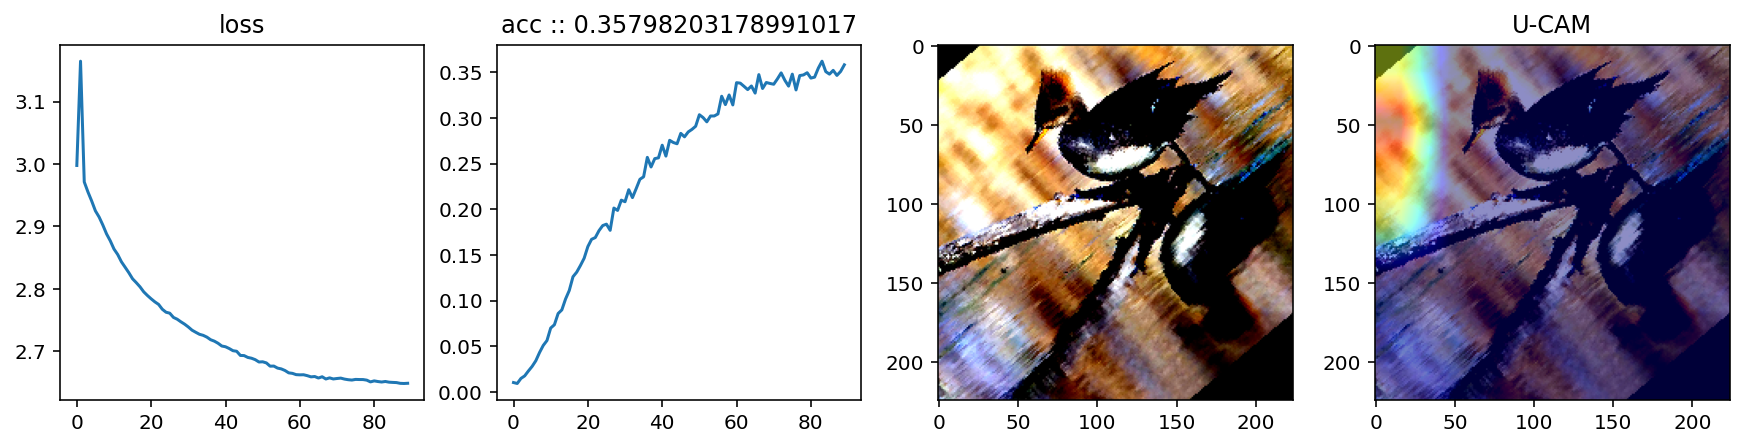

In [ ]:
kwargs = {'num_classes': classes}
mln = MixtureLogitNetwork(name='mln',y_dim=classes,USE_BN=True,k=5,
                                sig_min=0.01,sig_max=2., 
                                mu_min=-2,mu_max=+2,SHARE_SIG=True,
                                base = resnet18(pretrained=True, **kwargs)).to(device)
grad_cam_mln = GradCam_mln(model=mln, feature_module=mln.base.layer4, target_layer_names=["1"], device=device)

warm = 1.
optm = optim.SGD(mln.parameters(), lr=1e-3,momentum=0.9)
#optm = optim.Adam(resnet.parameters(), lr=1e-3)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optm, T_max=220)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optm, milestones=[60, 120, 180], gamma=0.2)
ce = nn.CrossEntropyLoss()

EPOCHS,print_every = 200, 1
loss_global = list()
acc_global = list()
for epoch in range(EPOCHS):
    loss_sum = 0.0
    batch_ind = 0
    scheduler.step(epoch)

    for batch_in,batch_out in train_iter:
        # Forward path
        mln_out = mln.forward(batch_in.to(device)) 
        pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
        target = torch.eye(classes)[batch_out].to(device)
        loss_out = mace_loss(pi,mu,sigma,target) 
#         loss = ce(mu, batch_out.to(device))
        loss = loss_out['mace_avg'] + 1. * loss_out['alea_avg']  - loss_out['epis_avg'] 
#         print(loss_out['mace_avg'].data, loss_out['epis_avg'].data, loss_out['alea_avg'].data)
        # Update
        optm.zero_grad() # reset gradient 
        loss.backward() # back-propagation 
        optm.step() # optimizer update
        # Track losses 
        loss_sum += loss
        batch_ind+=1 
#         print(torch.mean(sigma))
        #ucam = grad_cam_mln(batch_in[0].unsqueeze(0).to(device), target[0].unsqueeze(0).to(device))
        #plt.figure(figsize=(12,12))
        #plt.subplot(2,2,1)
        #plt.imshow(batch_in[0].permute(1,2,0))
        #plt.subplot(2,2,2)
        #plt.imshow(ucam, cmap=plt.get_cmap('jet'))
        #plt.show()
        
    loss_avg = loss_sum/len(train_iter)
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        test_res = func_eval(mln,test_iter,device)
        #outdist_res  = func_eval_base(model,outdist_iter,device)
        loss_global.append(loss_avg.item())
        acc_global.append(test_res['val_accr'])
        print(loss_avg)
        print(test_res['val_accr'])
        print(torch.mean(sigma))
        #print ("epoch:[%d/%d] loss:[%.3f] test_accr:[%.3f] "%(epoch,EPOCHS,loss_avg,test_res['val_accr'])) 
        #print (" [indist]  alea:[%.3f] epis:[%.7f]\n [outdist] alea:[%.3f] epis:[%.7f]"%(test_res['alea'],test_res['epis'], outdist_res['alea'],outdist_res['epis']))
        clear_output(wait=True)
        plt.figure(figsize=(15,15))
        plt.subplot(4,4,1)
        plt.title("loss")
        plt.plot(loss_global)
        plt.subplot(4,4,2)
        plt.title("acc :: "+str(test_res['val_accr']))
        plt.plot(acc_global)
        plt.subplot(4,4,3)
        plt.imshow(batch_in[0].permute(1,2,0).detach().cpu().numpy())
        plt.subplot(4,4,4)
        plt.title('U-CAM')
        cam = grad_cam_mln(batch_in.to(device), target[0].unsqueeze(0).to(device))
        plt.imshow(batch_in[0].permute(1,2,0).detach().cpu().numpy())
        plt.imshow(cam, alpha=0.45, cmap=plt.get_cmap('jet'))
        plt.show();
    
print ("Done")

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(4,4,1)
plt.title("loss")
plt.plot([val.item() for val in loss_global])

plt.subplot(4,4,2)
# plt.title("acc :: "+str(test_res['val_accr']))
plt.plot(acc_global)

plt.subplot(4,4,3)
plt.imshow(batch_in[0].permute(1,2,0).cpu().numpy())

plt.subplot(4,4,4)
plt.title('U-CAM')
cam = grad_cam_mln(batch_in[0].unsqueeze(0).to(device), target[0].unsqueeze(0).to(device))
plt.imshow(batch_in[0].permute(1,2,0).cpu().numpy())
plt.imshow(cam, alpha=0.45, cmap=plt.get_cmap('jet'))
plt.show();

In [ ]:
target[0].shape

In [ ]:
batch_in.shape